# Window size 2 second

### libraries

In [1]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import mode
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.utils.multiclass import unique_labels
from sklearn.gaussian_process.kernels import RBF

### Read files

In [2]:
path = 'C:\\Users\\s7277028\\Documents\\ARSSD\\Practicas\\Practica1\\OpportunityUCIDataset\\dataset\\' 
header_path = 'C:\\Users\\s7277028\\Documents\\ARSSD\\Practicas\\Practica1\\header.csv' 
header=pd.read_csv(header_path, names=['column',''])['column'].values
users = range(1,5)
trials = range(1,7)
all_data = pd.DataFrame()

### Generate all_data

In [3]:
for user in users:
    for trial in trials:
        if trial==6:
            filePath= path+'S'+str(user)+'-Drill.dat'
        else:
            filePath = path+'S'+str(user)+'-ADL'+str(trial)+'.dat'
        sadl1 = pd.read_csv(filePath, sep=' ', header=None)
        data = sadl1.iloc[:, :243]
        data.columns = header
        data=data[data.columns[np.r_[0:39,50:52,63:65,76:78,89:91,102:133]]]
        labels = sadl1.iloc[:,243]
        #find and remove rows with all nulls
        idx=data.index[data.isnull().all(1)]
        data = data[~data.index.isin(idx)]
        labels = labels[~labels.index.isin(idx)]
        #see how many there are of each label
        #what does it mean ?
        labels.value_counts()
        #fill missing values
        data = data.fillna(method='ffill',axis=1)
        data['user'] = user
        data['trial'] = trial

        #Why is it 0? What are the units? What does it mean?

        #Pre-processing: filtering
        #only data columns
        columns = data.columns[~data.columns.isin(['user', 'trial', 'MILLISEC'])]
        filtered_data = data[columns].rolling(11).median()
        filtered_data['MILLISEC'] = data.MILLISEC
        #what is the effect of the filter? what happens if the filter window is larger?

        #separate train and test'

        #segmentation

        filtered_data['time']=pd.to_datetime(data.MILLISEC, unit='ms')
        filtered_data.index=filtered_data.time
        keep = filtered_data.time.dt.second %2
        keep = keep - keep.shift() < 0
        
        #Feature extraction - only for first 132 columns
        means = filtered_data[columns].rolling('1S').mean()[keep]
        means.columns = [str(col) + '_mean' for col in means.columns]
        variances = filtered_data[columns].rolling('1S').var()[keep]
        variances.columns = [str(col) + '_var' for col in variances.columns]

        #talk about apply function
        labels.index = filtered_data.time
        mode_labels = labels.rolling('1S').apply(lambda x:mode(x)[0])[keep]

        #all features
        all_features = pd.concat([means, variances], axis=1)
        all_features['label'] = mode_labels 
        all_features['user'] = user
        all_features['trial'] = trial
        all_data = pd.concat([all_data, all_features])

C:\Users\s7277028\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning


### Explore the data

In [4]:
all_data.label.value_counts()

1.0    5763
2.0    3341
0.0    2669
4.0    2287
5.0     419
Name: label, dtype: int64

### Separate by class, see feature mean

In [5]:
all_data_0 = all_data[all_data.label==0]
all_data_1 = all_data[all_data.label==1]
all_data_2 = all_data[all_data.label==2]
all_data_4 = all_data[all_data.label==4]
all_data_5 = all_data[all_data.label==5]

### Graphic with histogram

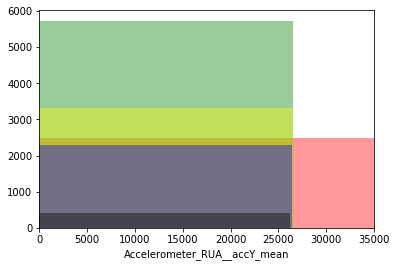

In [6]:
draw_col = 10
sns.distplot(all_data_0.iloc[:,draw_col], hist=True, kde=False, color='red').set(xlim=(0, 35000)) 
sns.distplot(all_data_1.iloc[:,draw_col], hist=True, kde=False, color='green')
sns.distplot(all_data_2.iloc[:,draw_col], hist=True, kde=False, color='yellow')
sns.distplot(all_data_4.iloc[:,draw_col], hist=True, kde=False, color='blue')
sns.distplot(all_data_5.iloc[:,draw_col], hist=True, kde=False, color='black')

# 1   -   Locomotion   -   Stand
# 2   -   Locomotion   -   Walk
# 4   -   Locomotion   -   Sit
# 5   -   Locomotion   -   Lie

### Graphic with kde

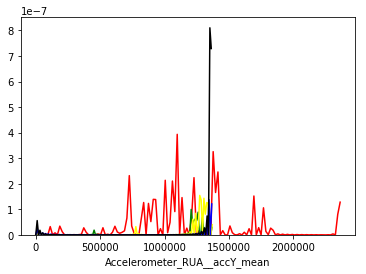

In [7]:
sns.distplot(all_data_0.iloc[:,draw_col], hist=False, kde=True, color='red')
sns.distplot(all_data_1.iloc[:,draw_col], hist=False, kde=True, color='green')
sns.distplot(all_data_2.iloc[:,draw_col], hist=False, kde=True, color='yellow')
sns.distplot(all_data_4.iloc[:,draw_col], hist=False, kde=True, color='blue')
sns.distplot(all_data_5.iloc[:,draw_col], hist=False, kde=True, color='black')

In [9]:
print(__doc__)

def plot_confusion_matrix(y_true, y_pred, 
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    cm = confusion_matrix(y_true, y_pred)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Automatically created module for IPython interactive environment


##  1. Random train test split using  `train_test_split`

In [10]:
# Dedife x as  all the feature columns (remove label, user and trial column)
X1 = all_data.loc[:,~all_data.columns.isin(['user', 'trial','label'])]
# Define y as the label
y1 = all_data.loc[:,all_data.columns.isin(['label'])]

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.33, random_state=42)

## Classifier comparison

## RBF SVM:

In [12]:
clf = KNeighborsClassifier(3)
clf.fit(X_train, y_train.values.ravel())
score = clf.score(X_test, y_test)
print("Score: ", score)
y_pred = clf.predict(X_test)

Score:  0.6587152123875287


In [13]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.59      0.66      0.62       918
         1.0       0.69      0.71      0.70      1874
         2.0       0.65      0.60      0.63      1084
         4.0       0.68      0.64      0.66       771
         5.0       0.77      0.55      0.64       132

   micro avg       0.66      0.66      0.66      4779
   macro avg       0.68      0.63      0.65      4779
weighted avg       0.66      0.66      0.66      4779



## confusion matrix


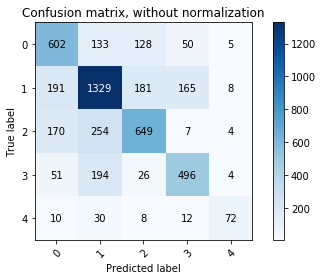

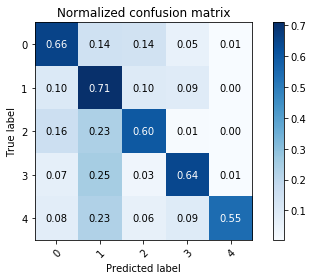

In [14]:
# Plot non-normalized confusion matrix
class_names= None
plot_confusion_matrix(y_test.astype(int), y_pred.astype(int),
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix

plot_confusion_matrix(y_test.astype(int), y_pred.astype(int) , normalize=True,
                      title='Normalized confusion matrix')

plt.show()

## 2. Use the data from user 1, 2 and 3 (all trials and drill session) as training data. Use data from user 4 (all trials) as test data.

In [15]:
#Data from user 1,2 and 3 with all trials and drill session
all_data_users_123 = all_data[all_data.user!=4]
#Data from user 4 with all trials
all_data_users_4 = all_data[all_data.user==4]
all_data_users_4 = all_data_users_4[all_data_users_4.trial!=6]
print("users: ", dict.fromkeys(all_data_users_123.user),"| trial: ",dict.fromkeys(all_data_users_123.trial))
print("users: ",dict.fromkeys(all_data_users_4.user),"| trial: ",dict.fromkeys(all_data_users_4.trial))

# Dedife train data
X_train = all_data_users_123.loc[:,~all_data.columns.isin(['user', 'trial','label'])]
y_train = all_data_users_123.loc[:,all_data.columns.isin(['label'])]

#Define test data
X_test = all_data_users_4.loc[:,~all_data.columns.isin(['user', 'trial','label'])]
y_test = all_data_users_4.loc[:,all_data.columns.isin(['label'])]

users:  {1: None, 2: None, 3: None} | trial:  {1: None, 2: None, 3: None, 4: None, 5: None, 6: None}
users:  {4: None} | trial:  {1: None, 2: None, 3: None, 4: None, 5: None}


## Classifier comparison

## RBF SVM:

In [16]:
clf.fit(X_train, y_train.values.ravel())
score = clf.score(X_test, y_test)
print("Score: ", score)
y_pred = clf.predict(X_test)

Score:  0.5716034271725826


In [17]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.62      0.51      0.56       697
         1.0       0.60      0.63      0.61       860
         2.0       0.51      0.69      0.59       484
         4.0       0.52      0.46      0.49       322
         5.0       0.66      0.26      0.37        88

   micro avg       0.57      0.57      0.57      2451
   macro avg       0.58      0.51      0.52      2451
weighted avg       0.58      0.57      0.57      2451



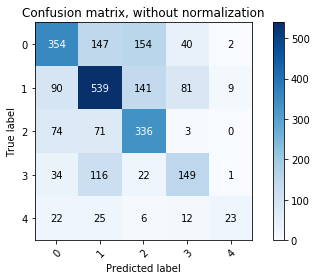

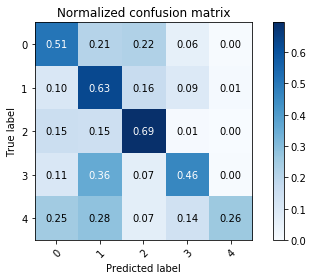

In [18]:
# Plot non-normalized confusion matrix
class_names= None
plot_confusion_matrix(y_test.astype(int), y_pred.astype(int),
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix

plot_confusion_matrix(y_test.astype(int), y_pred.astype(int) , normalize=True,
                      title='Normalized confusion matrix')

plt.show()

## 3. Use data from all users’ trials 1,2,3 and drill session as training data and trials 4 and 5 as test data. 

In [19]:
#Data from trials 1,2,3 and drill with all users
all_data_trials_1236 = all_data[all_data.trial.isin(['1','2','3','6'])]
# #Data from user 4 with all trials
all_data_trials_45 = all_data[all_data.trial.isin(['4','6'])]
print("users: ", dict.fromkeys(all_data_trials_45.user),"| trial: ",dict.fromkeys(all_data_trials_45.trial))
print("users: ",dict.fromkeys(all_data_trials_1236.user),"| trial: ",dict.fromkeys(all_data_trials_1236.trial))

users:  {1: None, 2: None, 3: None, 4: None} | trial:  {4: None, 6: None}
users:  {1: None, 2: None, 3: None, 4: None} | trial:  {1: None, 2: None, 3: None, 6: None}


In [20]:
# Dedife train data
X_train = all_data_trials_1236.loc[:,~all_data.columns.isin(['user', 'trial','label'])]
y_train = all_data_trials_1236.loc[:,all_data.columns.isin(['label'])]

#Define test data
X_test = all_data_trials_45.loc[:,~all_data.columns.isin(['user', 'trial','label'])]
y_test = all_data_trials_45.loc[:,all_data.columns.isin(['label'])]

## Classifier comparison

## RBF SVM:

In [21]:
clf.fit(X_train, y_train.values.ravel())
score = clf.score(X_test, y_test)
print("Score: ", score)
y_pred = clf.predict(X_test)

Score:  0.7583348033162816


In [22]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.52      0.71      0.60       653
         1.0       0.80      0.85      0.82      2641
         2.0       0.84      0.69      0.76      1603
         4.0       0.76      0.66      0.70       696
         5.0       0.81      0.45      0.58        76

   micro avg       0.76      0.76      0.76      5669
   macro avg       0.74      0.67      0.69      5669
weighted avg       0.77      0.76      0.76      5669



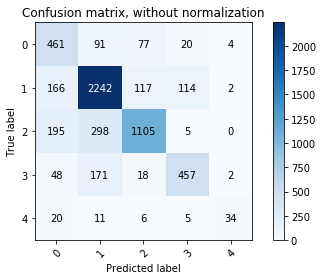

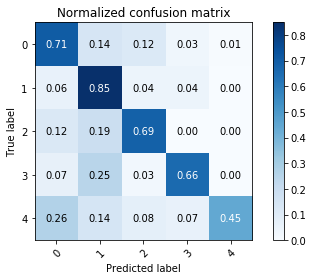

In [23]:
# Plot non-normalized confusion matrix
class_names= None
plot_confusion_matrix(y_test.astype(int), y_pred.astype(int),
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix

plot_confusion_matrix(y_test.astype(int), y_pred.astype(int) , normalize=True,
                      title='Normalized confusion matrix')

plt.show()